<a href="https://colab.research.google.com/github/german-cano/CTAO-image-processing-with-ants-algorithm/blob/main/MLperformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for automatic data classification with different machine learning models.
In this notebook I study the performance of different ML algorithms such as Knearest-neighbours, support vector machine and neural networks. Since the fine tuning of the models is not the purpose of this project I will not dedicate much time to it. The parameter of the models will then be set to default or close to it.

Mapie library is used along the notebook to quantify the uncertainty of the models within a confidence interval. However since the fundation of the mathematical concepts that this library uses were not clear to me at the moment of writing the report i did not include its results there.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install mapie

In [ ]:
%%capture
!pip install scikeras

In [ ]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import gc

#KNN
from sklearn.neighbors import KNeighborsClassifier

#SVC
from sklearn.svm import SVC

#NN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Masking, Conv1D, GlobalMaxPooling1D
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier

#conformal predictors
from mapie.classification import MapieClassifier
from mapie.multi_label_classification import MapieMultiLabelClassifier
from mapie.metrics import (classification_coverage_score_v2,
                           classification_mean_width_score)

In [ ]:
#shortcut for the paths
pth = '/content/drive/MyDrive/TFG/'

In [ ]:
#Here I load the data generated on past notebooks

#Load data
data = np.load(pth + 'ctadata_raw.npz') # imag, temp, event

imag = data['imag'] # shape (41083,1855), phe charge detected at each pixel
event = data['event'] # shape (41083,), Event classification, used for the ML algorithms
mask = data['mask'] #shape (41083, 1855), whether if each 'imag' value belongs to background noise or not
bckgr = data['bckgr_reduced'] #shape (2,), Background noise expresed as its deviation and mean after fitting the data to a gaussian
ev0 = data['flatpos']#shape(781,) , flatfield data position. Since those are triggered events we can take them out of classification

#Data preproccesing

In [ ]:
def filtflatfield(data, mask, ev0=ev0):
  '''
  data: phe charge per pixel
  mask: boolean, whether if each pixel data is noise
  ev0: positions within data of events classified as flatfield
  '''
  filtimag = []
  filtevent = []
  for index in range(data.shape[0]):
    if index in ev0:
      pass
    else:
      filtimag.append(data[index])
      filtevent.append(mask[index])

  return np.array(filtimag), np.array(filtevent)

In [ ]:
filtimag, filtevent = filtflatfield(imag, event)

In [ ]:
#In order to train the diferent ML models we need the data to be normalized
#Normalizing data is common practice in ML to improve models performance
#Here i also split the data into training and test sets.

def split_norm( X, Y):
   '''
   X: Set of events
   Y: classification of each event
   '''

    X_train_cal, X_test, Y_train_cal, Y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True )
    X_train, X_cal, Y_train, Y_cal = train_test_split(X_train_cal,Y_train_cal, test_size = 0.25, shuffle = True )

    #normalizing the data
    scaler = preprocessing.MaxAbsScaler().fit(X_train) #Scale such that the maximum value is 1.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) # use the same transformation on test data
    X_cal = scaler.transform(X_cal)

    return X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal


In [ ]:
#code to split and normalize raw graphs data.


def graph_split_norm( X, Y):
     '''
   X: Set of events as graphs
   Y: classification of each event
   '''

    X_train_cal, X_test, Y_train_cal, Y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True )
    X_train, X_cal, Y_train, Y_cal = train_test_split(X_train_cal,Y_train_cal, test_size = 0.25, shuffle = True )

    #normalizing the data
    scaler = {}
    for i in range(X_train.shape[2]):
      scaler[i] = preprocessing.MaxAbsScaler()
      X_train[:,:,i] = scaler[i].fit_transform(X_train[:,:,i])
      X_test[:,:,i] = scaler[i].fit_transform(X_test[:,:,i])
      X_cal[:,:,i] = scaler[i].fit_transform(X_cal[:,:,i])

    return X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal



In [ ]:
#redefinition of labels to classiffy the data

filtmask = filtevent.copy()
for index in range(filtmask.shape[0]):
  if filtmask[index] == 2:
    filtmask[index] = 0
  elif filtmask[index] == 32:
    filtmask[index] = 1


In [ ]:
X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal = split_norm(filtimag, filtmask)

# SCI-KIT LEARN MODELS

## KNN

In [ ]:
def KNNmodel(neighbors, Xtrain,Xtest, Xcal ,Ytrain, Ytest , Ycal):
  #neighbors: number of neighbours to consider

  KNN = KNeighborsClassifier(n_neighbors = neighbors)
  #mapie wrapper to quantify model uncertainty
  mapie_KNNclassifier = MapieClassifier(estimator=KNN, method='lac', cv=5)
  mapie_KNNclassifier.fit(Xtrain, Ytrain)

  pred,predps = mapie_KNNclassifier.predict(Xcal, alpha = 0.05) #95% of certainty
  KNNcoverage = classification_coverage_score_v2(Ycal, predps) #fraction of true labels that lie within prediction set

  print(f'With 95% of certainty, the model precission on calibration set is {KNNcoverage}')

  #confusion matrix for performance visualization
  cm = confusion_matrix(Ytest, pred, labels= [0,1], normalize='all')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= [0,1])

  disp.plot()
  #plt.savefig('knnraw.png')
  gc.collect() #this free ram memory
  return

With 95% of certainty, the model precission is [0.94330728]


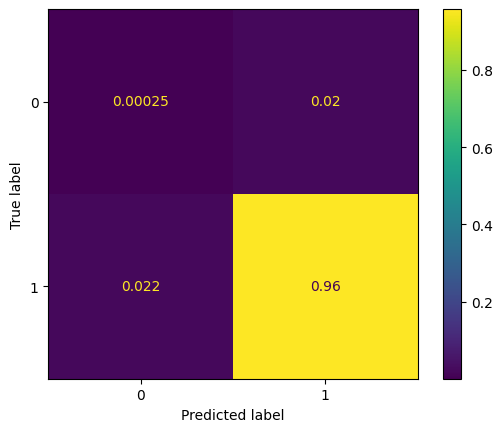

In [ ]:
KNNmodel(3, X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal )

##SVM


In [ ]:
def SVMmodel(C, gamma, Xtrain , Xtest, Xcal, Ytrain, Ytest, Ycal):
  '''
  C, gamma: equivalent of sigma and lambda parameters for gaussian kernel
  '''

  SVM = SVC(kernel = 'rbf',C=C, gamma=gamma,  class_weight = 'balanced')
  SVM.fit(Xtrain, Ytrain)
  #mapie wrapper to quantify model uncertainty
  mapie_SVMclassifier = MapieClassifier(estimator=SVM, method='lac', cv='prefit')
  mapie_SVMclassifier.fit(Xcal, Ycal)

  pred, predps = mapie_SVMclassifier.predict(Xcal, alpha = 0.05) #95% confidence
  SVMcoverage = classification_coverage_score_v2(Ycal, predps)

  print(f'With 95% of certainty, the model precission on calibration set is {SVMcoverage}')

  pred = SVM.predict(Xtest)

  #confusion matrix for performance visualization
  cm = confusion_matrix(Ytest, pred, labels= [0,1], normalize='all')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= [0,1])

  disp.plot()
  #plt.savefig('svmraw.png')

  gc.collect()

  return

In [ ]:
C=10
gamma=0.1

SVMmodel(C,gamma, X_train, X_test, X_cal ,Y_train ,Y_test ,Y_cal)

#Simple DNN

In [ ]:
def NNmodeltrain(model,epochs, batch, Xtrain,Xtest ,Xcal ,Ytrain ,Ytest, Ycal):
  '''
  model: architecture to train, must be defined outside the function
  epochs: number of iterations of model trainning
  batch: data chunks size the model will consider during trainning. Should be
        equal to the number of neurons of the first layer.
  '''

  clf = KerasClassifier(model)

  clf.fit(Xtrain, Ytrain, epochs = epochs, batch_size = batch ,
          validation_data = (Xcal, Ycal), verbose = 2)
  #mapie wrapper to quantify model uncertainty
  mapie_NNclassifier =  MapieClassifier(estimator=clf, method='lac', cv='prefit')
  mapie_NNclassifier.fit(Xcal, Ycal)

  pred, predps = mapie_NNclassifier.predict(Xtest, alpha = 0.05) #95% confidence
  NNcoverage = classification_coverage_score_v2(Ytest, predps)

  print(f'With 95% of certainty, the model precission on calibration set is {NNcoverage}')

  cm = confusion_matrix(Ytest, pred, labels = [0, 1], normalize='all')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])

  disp.plot()

  plt.savefig('NNraw.png')

In [ ]:
#Here I create the model

L = len(X_train[0])

model = Sequential()
model.add(Dense(10, input_shape=(L,), activation = 'relu')) #relu stands for rectified linear function

model.add(Dense(1, activation = 'sigmoid')) #I want values between 0 and 1, that is why I use 'sigmoid'

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 10)                  │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,571 (72.54 KB)

 Trainable params: 18,571 (72.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#specify loss function and metrics to consider during trainning
model.compile(loss = 'binary_focal_crossentropy' , optimizer = 'adam', metrics = ['binary_accuracy'])

Epoch 1/10
2418/2418 - 6s - 2ms/step - binary_accuracy: 0.9807 - loss: 0.0283 - val_binary_accuracy: 0.9813 - val_loss: 0.0270
Epoch 2/10
2418/2418 - 5s - 2ms/step - binary_accuracy: 0.9809 - loss: 0.0269 - val_binary_accuracy: 0.9813 - val_loss: 0.0270
Epoch 3/10
2418/2418 - 6s - 2ms/step - binary_accuracy: 0.9809 - loss: 0.0262 - val_binary_accuracy: 0.9813 - val_loss: 0.0277
Epoch 4/10
2418/2418 - 4s - 2ms/step - binary_accuracy: 0.9809 - loss: 0.0254 - val_binary_accuracy: 0.9813 - val_loss: 0.0275
Epoch 5/10
2418/2418 - 10s - 4ms/step - binary_accuracy: 0.9809 - loss: 0.0245 - val_binary_accuracy: 0.9813 - val_loss: 0.0272
Epoch 6/10
2418/2418 - 5s - 2ms/step - binary_accuracy: 0.9809 - loss: 0.0237 - val_binary_accuracy: 0.9813 - val_loss: 0.0285
Epoch 7/10
2418/2418 - 4s - 2ms/step - binary_accuracy: 0.9809 - loss: 0.0227 - val_binary_accuracy: 0.9813 - val_loss: 0.0285
Epoch 8/10
2418/2418 - 9s - 4ms/step - binary_accuracy: 0.9809 - loss: 0.0218 - val_binary_accuracy: 0.9813 - 

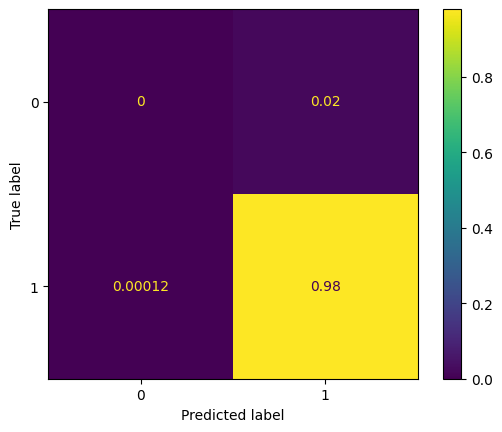

In [ ]:
NNmodeltrain(model, 10, 10, X_train, X_test, X_cal, Y_train, Y_test, Y_cal)

#Performance on Graphs

So far we just considered the raw data for classification. On the following I will retrain each model with the data obtained from the graphs representation adjusting it to the limitation of the models. Graphs data is three-dimensional since appart from the event and phe charge values that we had before now it also has information about the connection between nodes. Nevertheless, scikit-learn models do not accept 3D data. To compare the performance on each dataset I created a third dataset made of the mean value of connected nodes, this new dataset is again two-dimensional at the cost of loosing the information relative to node connections.

On the other hand, since keras library allows it, an architecture for 3D data is also designed and trained on graphs data.

In [ ]:
#load graphs
graphs = np.load(pth + 'finalgraph.npz')

In [ ]:
graphsdata = graphs['graph']#3D graph data

In [ ]:
X = np.load(pth + 'TFG.npz')#2D graph data

In [ ]:
X = X['X'] #Graphs with edges expressed as the mean of their nodes

In [ ]:
#filter out flatfield events
filgraph, _ = filtflatfield(graphsdata, event)
X, _ = filtflatfield(X, event)

In [ ]:
X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal = split_norm(X, filtmask)

With 95% of certainty, the model precission is [0.97990324]


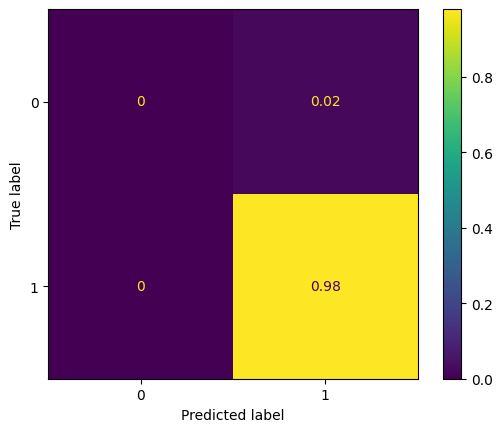

In [ ]:
KNNmodel(3,X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal)

With 95% of certainty, the model precission is [0.98164]


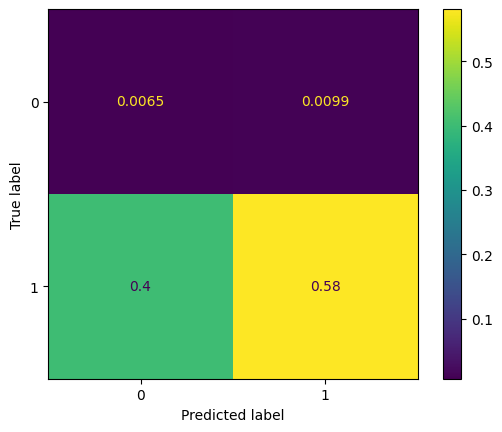

In [ ]:
C = 5
gamma = 0.05
SVMmodel(C, gamma, X_train, X_test ,X_cal ,Y_train ,Y_test, Y_cal)

For the Neural network I will train two different models. One will be the same as the used before which requires 2D data in order to do proper comparison, the second will be a diferent model to be trained with the graphs raw 3D data which will try to learn from the configuration of the nodes determined by the ants.

In [ ]:
X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal = split_norm(X, filtmask)


In [ ]:
#Same model as before:

L = len(X_train[0])

model = Sequential()
model.add(Dense(10, input_shape=(L,), activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #I want values between 0 and 1, that is why I use 'sigmoid'

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 10)                  │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,571 (72.54 KB)

 Trainable params: 18,571 (72.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#here I fine-tuned a bit the loss function parameters
loss_fn = keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing = False,
    alpha=0.000001,
    gamma=1.,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="sum_over_batch_size",
    name="binary_focal_crossentropy",
)

In [ ]:
model.compile(loss = loss_fn ,
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics = ['binary_accuracy'])

Epoch 1/10
2418/2418 - 100s - 42ms/step - binary_accuracy: 0.9811 - loss: 3.5554e-04 - val_binary_accuracy: 0.9813 - val_loss: 3.5256e-04
Epoch 2/10
2418/2418 - 7s - 3ms/step - binary_accuracy: 0.9811 - loss: 3.5216e-04 - val_binary_accuracy: 0.9813 - val_loss: 3.4766e-04
Epoch 3/10
2418/2418 - 9s - 4ms/step - binary_accuracy: 0.9811 - loss: 3.5135e-04 - val_binary_accuracy: 0.9813 - val_loss: 3.4670e-04
Epoch 4/10
2418/2418 - 6s - 3ms/step - binary_accuracy: 0.9811 - loss: 3.5237e-04 - val_binary_accuracy: 0.9813 - val_loss: 3.4551e-04
Epoch 5/10
2418/2418 - 9s - 4ms/step - binary_accuracy: 0.9811 - loss: 3.5232e-04 - val_binary_accuracy: 0.9813 - val_loss: 3.4517e-04
Epoch 6/10
2418/2418 - 6s - 2ms/step - binary_accuracy: 0.9811 - loss: 3.5192e-04 - val_binary_accuracy: 0.9813 - val_loss: 3.4481e-04
Epoch 7/10
2418/2418 - 9s - 4ms/step - binary_accuracy: 0.9811 - loss: 3.5110e-04 - val_binary_accuracy: 0.9813 - val_loss: 3.4473e-04
Epoch 8/10
2418/2418 - 5s - 2ms/step - binary_accura

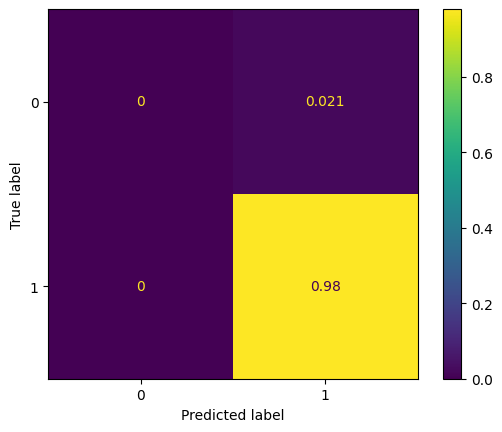

In [ ]:
NNmodeltrain(model,10,10,X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal)

In [ ]:
#Now we will consider 3D graphs data
filtedgraph, _ = filtflatfield(graphsdata, event)

In [ ]:
X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal = graph_split_norm(filtedgraph, filtmask)

In [ ]:

#Here I create the model
L = len(X_train[0])

#considerar cambiar la shape del resto de capas
graphmodel = Sequential()
graphmodel.add(Dense(20, input_shape=(L,2,), activation = 'relu'))

graphmodel.add(Conv1D(20, kernel_size=2, activation='relu'))  # 1D convolution with kernel size 2
graphmodel.add(GlobalMaxPooling1D())  # Global max pooling to aggregate information
graphmodel.add(Dense(20, activation = 'relu'))
#model.add(Dense(30, activation = 'relu'))

graphmodel.add(Dense(1, activation = 'sigmoid'))

graphmodel.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 1856, 20)            │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1855, 20)            │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 20)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321 (5.16 KB)

 Trainable params: 1,321 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss_fn = keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing = True,
    alpha=0.00001,
    gamma=4.,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="sum_over_batch_size",
    name="binary_focal_crossentropy",
)

In [ ]:
graphmodel.compile(loss = loss_fn ,
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics = ['binary_accuracy'])

In [ ]:
NNmodeltrain(graphmodel, 5, 20, X_train, X_test ,X_cal ,Y_train ,Y_test, Y_cal)

#Balanced dataset

Since the dataset is imbalanced I also studied the possibility of making up for that imbalance by generating aritificial pedestal events. I retrain all the models except for the convolutional neural network.

In [ ]:
%%capture
!pip install -U imbalanced-learn


In [ ]:
from imblearn.over_sampling import RandomOverSampler


In [ ]:
#artificially oversample the class with less events
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, Y_train)

In [ ]:
#Same model as before:

L = len(X_train[0])

model = Sequential()
model.add(Dense(10, input_shape=(L,), activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #I want values between 0 and 1, that is why I use 'sigmoid'

model.summary()

In [ ]:

model.compile(loss = 'binary_crossentropy' ,
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics = ['binary_accuracy'])

Epoch 1/10
4746/4746 - 10s - 2ms/step - binary_accuracy: 0.8117 - loss: 0.4047 - val_binary_accuracy: 0.6209 - val_loss: 0.4339
Epoch 2/10
4746/4746 - 8s - 2ms/step - binary_accuracy: 0.8117 - loss: 0.4048 - val_binary_accuracy: 0.6209 - val_loss: 0.4980
Epoch 3/10
4746/4746 - 10s - 2ms/step - binary_accuracy: 0.8117 - loss: 0.4047 - val_binary_accuracy: 0.6209 - val_loss: 0.4995
Epoch 4/10
4746/4746 - 9s - 2ms/step - binary_accuracy: 0.8117 - loss: 0.4048 - val_binary_accuracy: 0.6209 - val_loss: 0.5284
Epoch 5/10
4746/4746 - 10s - 2ms/step - binary_accuracy: 0.8117 - loss: 0.4046 - val_binary_accuracy: 0.6209 - val_loss: 0.5048
Epoch 6/10
4746/4746 - 21s - 4ms/step - binary_accuracy: 0.8117 - loss: 0.4045 - val_binary_accuracy: 0.6209 - val_loss: 0.5398
Epoch 7/10
4746/4746 - 19s - 4ms/step - binary_accuracy: 0.8117 - loss: 0.4047 - val_binary_accuracy: 0.6209 - val_loss: 0.4811
Epoch 8/10
4746/4746 - 10s - 2ms/step - binary_accuracy: 0.8117 - loss: 0.4046 - val_binary_accuracy: 0.62

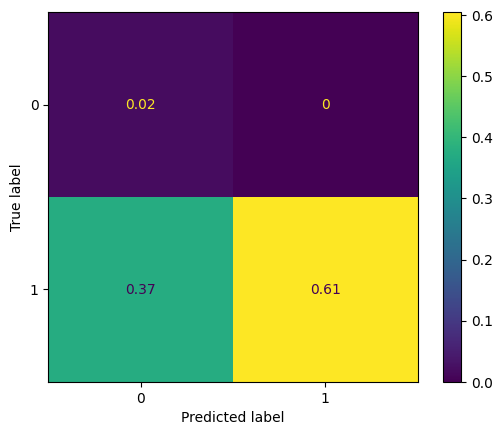

In [ ]:
NNmodeltrain(model,10,10,X_res,X_test ,X_cal ,y_res ,Y_test, Y_cal)

With 95% of certainty, the model precission on calibration set is [1.]


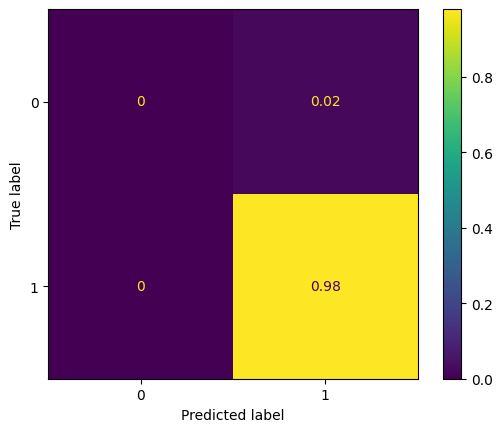

In [ ]:
KNNmodel(3,X_res,X_test ,X_cal ,y_res ,Y_test, Y_cal)

In [ ]:
C = 5
gamma = 0.05
SVMmodel(C, gamma, X_res, X_test ,X_cal ,y_res ,Y_test, Y_cal)

In [ ]:
#Repeat for 2D graph data
X_train,X_test ,X_cal ,Y_train ,Y_test, Y_cal = split_norm(X, filtmask)

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, Y_train)

With 95% of certainty, the model precission on calibration set is [0.87396105]


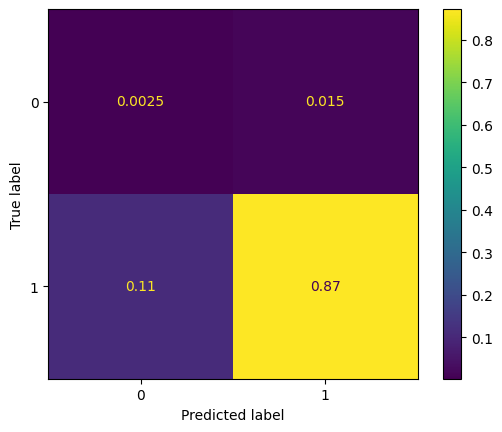

In [ ]:
#raw data

KNNmodel(3,X_res,X_test ,X_cal ,y_res ,Y_test, Y_cal)

Epoch 1/10
4741/4741 - 11s - 2ms/step - binary_accuracy: 0.7022 - loss: 0.6133 - val_binary_accuracy: 0.7348 - val_loss: 0.5420
Epoch 2/10
4741/4741 - 8s - 2ms/step - binary_accuracy: 0.8564 - loss: 0.4088 - val_binary_accuracy: 0.7961 - val_loss: 0.4166
Epoch 3/10
4741/4741 - 9s - 2ms/step - binary_accuracy: 0.9055 - loss: 0.2995 - val_binary_accuracy: 0.8264 - val_loss: 0.3688
Epoch 4/10
4741/4741 - 11s - 2ms/step - binary_accuracy: 0.9298 - loss: 0.2362 - val_binary_accuracy: 0.8216 - val_loss: 0.3908
Epoch 5/10
4741/4741 - 8s - 2ms/step - binary_accuracy: 0.9420 - loss: 0.1947 - val_binary_accuracy: 0.8586 - val_loss: 0.3524
Epoch 6/10
4741/4741 - 12s - 2ms/step - binary_accuracy: 0.9515 - loss: 0.1637 - val_binary_accuracy: 0.8757 - val_loss: 0.3491
Epoch 7/10
4741/4741 - 10s - 2ms/step - binary_accuracy: 0.9604 - loss: 0.1381 - val_binary_accuracy: 0.8867 - val_loss: 0.3539
Epoch 8/10
4741/4741 - 8s - 2ms/step - binary_accuracy: 0.9669 - loss: 0.1190 - val_binary_accuracy: 0.9040

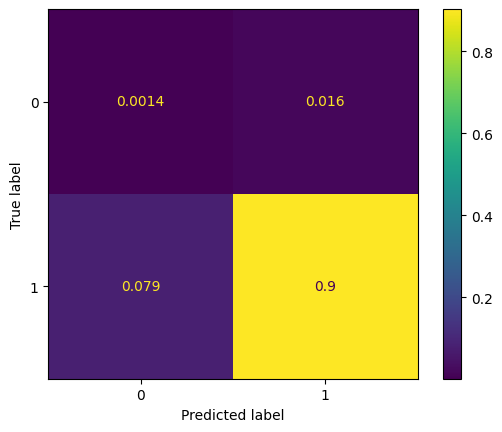

In [ ]:
NNmodeltrain(model,10,10,X_res,X_test ,X_cal ,y_res ,Y_test, Y_cal)

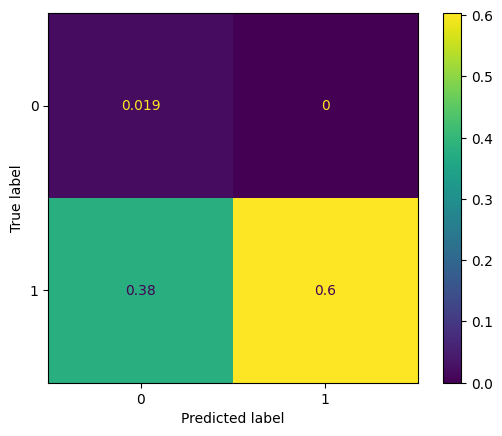

In [ ]:
C = 5
gamma = 0.05
SVMmodel(C, gamma, X_res, X_test ,X_cal ,y_res ,Y_test, Y_cal)